In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import math
import scipy
import requests
import warnings
import h5py
import fsspec
from pyproj import Proj, CRS
import pysolid
import pymap3d as pm   #for transformation between ENU and llh

import matplotlib.pyplot as plt

from isce3.core import Ellipsoid as ellips

from osgeo import gdal, osr

import shapely.wkt as wkt
from shapely import geometry

from src.ALE_utils import oversample_slc, findCR, en2rdr
from src.cslc_utils import colorize, getbasemaps
from src.RLE_utils import array2raster

import os
import timeit
warnings.filterwarnings('ignore')

In [2]:
# Start runtime evaluation
start = timeit.default_timer()

In [3]:
# Parameters for papermill
data_dir = '/work/users/jinwook/Central_Valley/P035/stack'
save_dir = '/work/users/jinwook/Central_Valley/P035'
burst_id = 't035_073240_iw3'
date = '20230506'
snr_threshold = 13
solidtide = 'True'

In [4]:
pol = 'VV'
path_h5 = f'{data_dir}/{burst_id}/{date}/{burst_id}_{date}.h5' 
s3f = fsspec.open(path_h5, mode='rb', anon=True, default_fill_cache=False)

# Load the CSLC and necessary metadata
grid_path = f'data'
metadata_path = f'metadata'
burstmetadata_path = f'metadata/processing_information/input_burst_metadata'
id_path = f'identification'

with h5py.File(s3f.open(),'r') as h5:
    cslc = h5[f'{grid_path}/{pol}'][:]
    azimuth_carrier_phase = h5[f'{grid_path}/azimuth_carrier_phase'][:]
    flattening_phase = h5[f'{grid_path}/flattening_phase'][:]
    xcoor = h5[f'{grid_path}/x_coordinates'][:]
    ycoor = h5[f'{grid_path}/y_coordinates'][:]
    dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
    dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
    epsg = h5[f'{grid_path}/projection'][()].astype(int)
    sensing_start = h5[f'{burstmetadata_path}/sensing_start'][()].astype(str)
    sensing_stop = h5[f'{burstmetadata_path}/sensing_stop'][()].astype(str)
    dims = h5[f'{burstmetadata_path}/shape'][:]
    bounding_polygon =h5[f'{id_path}/bounding_polygon'][()].astype(str) 
    orbit_direction = h5[f'{id_path}/orbit_pass_direction'][()].astype(str)
    center_lon, center_lat = h5[f'{burstmetadata_path}/center']
    compass_ver = h5[f'{metadata_path}/processing_information/algorithms/COMPASS_version'][()].astype(str)
    
# Get bounding box
cslc_poly = wkt.loads(bounding_polygon)

# Deramp the cslc
ramp = np.exp(1j*azimuth_carrier_phase)
cslc = cslc*np.conj(ramp)

# Unflatten the cslc
flat_phase = np.exp(1j*flattening_phase)
cslc = cslc*np.conj(flat_phase) 

print(f'COMPASS version: {compass_ver}')
print(f'orbit direction: {orbit_direction}')

COMPASS version: 0.3.1
orbit direction: Ascending


In [5]:
# Read to pandas dataframe and rename columns
df = pd.read_csv(f'crdata.csv')
df.rename(columns={'Corner reflector ID':'ID'}, inplace=True)
df.rename(columns={'Latitude (deg)':'lat'}, inplace=True) 
df.rename(columns={'Longitude (deg)':'lon'}, inplace=True) 
df.rename(columns={'Azimuth (deg)':'azm'}, inplace=True)
df.rename(columns={'Tilt / Elevation angle (deg)':'tilt'}, inplace=True)
df.rename(columns={'Height above ellipsoid (m)':'hgt'}, inplace=True) 
df.rename(columns={'Side length (m)':'slen'}, inplace=True)
df.slen = np.round(df.slen,1)
df.head()

,ID,lat,lon,hgt,azm,tilt,slen
0,OPERA_CR3,36.187509,-120.758987,779.755,1,13.5,2.4
1,OPERA_CR4,36.187090,-120.758347,788.546,181,15.8,2.4


In [6]:
if (solidtide == 'True' ):
    #solid earth tide correction with PySolid
    dateformat = '%Y-%m-%d %H:%M:%S.%f'  #date format of input azimuth time
    dt0 = dt.datetime.strptime(sensing_start,dateformat)
    dt1 = dt.datetime.strptime(sensing_stop,dateformat)
    step_sec = 5                        # sample spacing in time domain in seconds

    for idx, row in df.iterrows():

        llh = [np.deg2rad(row['lon']), np.deg2rad(row['lat']), row['hgt']]  #lon/lat/hgt

        _elp = ellips()
        xyz = _elp.lon_lat_to_xyz(llh) #xyz coordinate of CR

        # compute SET via pysolid
        (dt_out,
         tide_e,
         tide_n,
         tide_u) = pysolid.calc_solid_earth_tides_point(np.rad2deg(llh[1]), np.rad2deg(llh[0]), dt0, dt1,
                                                    step_sec=step_sec,
                                                    display=False,
                                                    verbose=False)

        tide_e = np.mean(tide_e[0:2])
        tide_n = np.mean(tide_n[0:2])
        tide_u = np.mean(tide_u[0:2])

        #updating lat,lon,hgt after SET correction
        llh = pm.enu2geodetic(tide_e, tide_n, tide_u,np.rad2deg(llh[1]),np.rad2deg(llh[0]),llh[2],deg=True)

        df.loc[idx,'lat'] = llh[0]
        df.loc[idx,'lon'] = llh[1]
        df.loc[idx,'hgt'] = llh[2]   

PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 36.187508643/-120.75898696300001 degree
PYSOLID: start UTC: 2023-05-06T02:07:43.272580
PYSOLID: end   UTC: 2023-05-06T02:07:46.382637
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 36.187090217/-120.758346632 degree
PYSOLID: start UTC: 2023-05-06T02:07:43.272580
PYSOLID: end   UTC: 2023-05-06T02:07:46.382637
PYSOLID: time step: 5 seconds


In [7]:
if 'lon' not in df.keys():
    raise SystemExit('No CRs found within burst, exit notebook')

In [8]:
#calculating the locations of CRs in SAR image
UTMx = []
UTMy = []
xloc = []
yloc = []
xloc_float = []
yloc_float = []
_in = []

for idx, row in df.iterrows():
    
    _Proj = Proj(CRS.from_epsg(epsg))
    _x, _y = _Proj(row['lon'], row['lat'],inverse=False)     #conversion of lat/lon of CRs to UTM coordinates
    
    #location of CRs in SLC image
    _xloc = int((_x-xcoor[0])/dx)    
    _yloc = int((_y-ycoor[0])/dy)
    
    UTMx.append(_x) 
    UTMy.append(_y)
    xloc.append(_xloc)
    yloc.append(_yloc)
    xloc_float.append((_x-xcoor[0])/dx)
    yloc_float.append((_y-ycoor[0])/dy)
    _in.append(cslc_poly.contains(geometry.Point(row['lon'], row['lat'])))
    
df['UTMx'] = UTMx
df['UTMy'] = UTMy
df['xloc'] = xloc
df['yloc'] = yloc
df['xloc_float'] = xloc_float
df['yloc_float'] = yloc_float
df['inPoly'] = _in

#checking whether CRs are in SLC coverage. Including only CRs within SLC image
df = df[df['inPoly']==True]
df.drop('inPoly', axis=1, inplace=True)
df = df.reset_index(drop=True)
df.head()

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float
0,OPERA_CR3,36.187509,-120.758987,779.603309,1,13.5,2.4,701513.627735,4.007074e+06,15148,2480,15148.225547,2480.124562
1,OPERA_CR4,36.187090,-120.758347,788.394307,181,15.8,2.4,701572.288669,4.007029e+06,15159,2484,15159.957734,2484.633670


In [9]:
# selecting CRs according to orbit direction
# if orbit_direction == 'Ascending':
#     df_filter = df[(df['azm']>140) & (df['azm']<220)].reset_index(drop=True)
#     #only west-looking CRs (for right-looking ascending)
# else:     #Descending
#     df_filter = df[~((df['azm']>140) & (df['azm']<220))].reset_index(drop=True)
#     #only east-looking CRs (for right-looking descending)

if orbit_direction == 'Ascending':
    df_filter = df[(df['azm']==1)].reset_index(drop=True)
    #only west-looking CRs (for right-looking ascending)
else:     #Descending
    df_filter = df[~(df['azm']==1)].reset_index(drop=True)
    #only east-looking CRs (for right-looking descending)

In [10]:
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float
0,OPERA_CR3,36.187509,-120.758987,779.603309,1,13.5,2.4,701513.627735,4.007074e+06,15148,2480,15148.225547,2480.124562


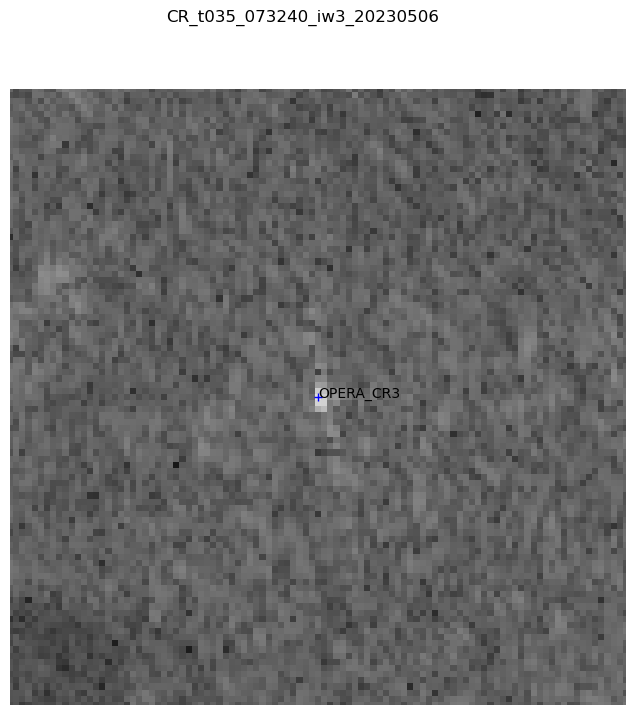

In [11]:
#Displaying SLC image
buffer = 50
minX = df_filter['xloc'].min() - buffer
maxX = df_filter['xloc'].max() + buffer
minY = df_filter['yloc'].min() - buffer
maxY = df_filter['yloc'].max() + buffer

scale_ = 1.0
exp_ = 0.15

fig, ax = plt.subplots(figsize=(12, 8))
cax=ax.imshow(scale_*(np.abs(cslc))**exp_, cmap='gray',interpolation=None,origin='upper')
ax.set_xlim(minX,maxX)
ax.set_ylim(maxY,minY)

for sl in pd.unique(df_filter.slen):
    xx = df_filter.loc[df_filter['slen']==sl]['xloc']
    yy = df_filter.loc[df_filter['slen']==sl]['yloc']
    ID = df_filter.loc[df_filter['slen']==sl]['ID']
    
    if sl == 2.4:
        color='blue'
    elif sl == 4.8:
        color='red'
    elif sl == 2.8:
        color='yellow'
    else:
        color='green'
    
    ax.scatter(xx,yy,color=color,marker="+",lw=1)
    for _ID,_xx,_yy in zip(ID,xx,yy):
        ax.annotate(_ID, (_xx, _yy), fontsize=10)

ax.set_aspect(1)
ax.axis('off')
fig.suptitle(f'CR_{burst_id}_{date}')
fig.savefig(f'{save_dir}/pngs/S1_CSLC_CRs_{burst_id}_{date}.png',dpi=300,bbox_inches='tight')

In [12]:
xcorr_min = xcoor.min()
ycoor_max = ycoor.max()

In [13]:
minX_utm = xcorr_min + (minX - 1)*dx
maxX_utm = xcorr_min + (maxX - 1)*dx
minY_utm = ycoor_max + (minY - 1)*dy
maxY_utm = ycoor_max + (maxY - 1)*dy

_ = np.abs(cslc[minY:maxY,minX:maxX])
tmpfile = '_tmp.tif'
if os.path.exists(tmpfile): os.remove(tmpfile)
array2raster(tmpfile,minX_utm,minY_utm,dx,dy,int(epsg),_)

In [14]:
import rioxarray
import matplotlib as mpl

# Read the merged raster file
src = rioxarray.open_rasterio(tmpfile)
cr_cslc_geo = src.rio.reproject("EPSG:4326")             # Folium maps are in EPSG:4326
minlon,minlat,maxlon,maxlat = cr_cslc_geo.rio.bounds()

In [15]:
cr_cslc_geo_dB = 20*np.log10(cr_cslc_geo.values[0])
cr_cslc_geo_dB[cr_cslc_geo_dB>100] = np.nan
cr_cslc_geo_dB[cr_cslc_geo_dB<-100] = np.nan

colored_dB = colorize(cr_cslc_geo_dB,'gray',cmin=0,cmax=100)


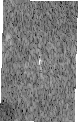

In [16]:
meanLat = df_filter['lat'].mean()
meanLon = df_filter['lon'].mean()

import folium
from folium import plugins

m = folium.Map(location=[meanLat, meanLon], zoom_start=14, tiles='Stamen Terrain', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

# Overlay CSLC on a basemap
folium.raster_layers.ImageOverlay(colored_dB, 
                                        opacity=0.8, 
                                        bounds=[[minlat,minlon],[maxlat,maxlon]],
                                        interactive=False,
                                        name='OPERA CSLC',
                                        show=True).add_to(m)

# for idx, row in df_filter.iterrows():
for idx, row in df.iterrows():
    feature_gp = folium.FeatureGroup(name=row['ID'])
    
    folium.Marker(
        location=[row['lat'], row['lon']],
      popup=row['ID']).add_to(feature_gp)
    feature_gp.add_to(m)

#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=300, height=300)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

m

In [17]:
def get_snr_peak(img: np.ndarray, cutoff_percentile: float=3.0):
    '''
    Estimate the signal-to-noise ration (SNR) of the peak
    in the input image patch
    Parameter
    ---------
    img: numpy.ndarray
        SLC image patch to calculate the SNR
    cutout: float
        Cutout ratio of high and low part of the signal to cutoff
    Returns
    -------
    snr_peak_db: float
        SNR of the peak in decibel (db)
    '''

    power_arr = img.real ** 2 + img.imag ** 2

    # build up the mask array
    thres_low = np.nanpercentile(power_arr, cutoff_percentile)
    thres_high = np.nanpercentile(power_arr, 100 - cutoff_percentile)
    mask_threshold = np.logical_and(power_arr < thres_low,
                                    power_arr > thres_high)
    mask_invalid_pixel = np.logical_and(power_arr <= 0.0,
                                        np.isnan(power_arr))
    ma_power_arr = np.ma.masked_array(power_arr,
                                      mask=np.logical_and(mask_threshold,
                                                          mask_invalid_pixel))

    peak_power = np.nanmax(power_arr)
    mean_background_power = np.mean(ma_power_arr)

    snr_peak_db = np.log10(peak_power / mean_background_power) * 10.0

    return snr_peak_db

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR,snr
0,OPERA_CR3,36.187509,-120.758987,779.603309,1,13.5,2.4,701513.627735,4.007074e+06,15148,2480,15148.225547,2480.124562,15148.343446,2480.110353,14.517959


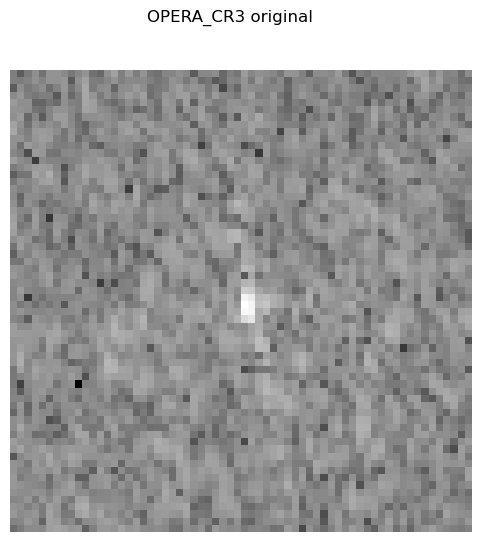

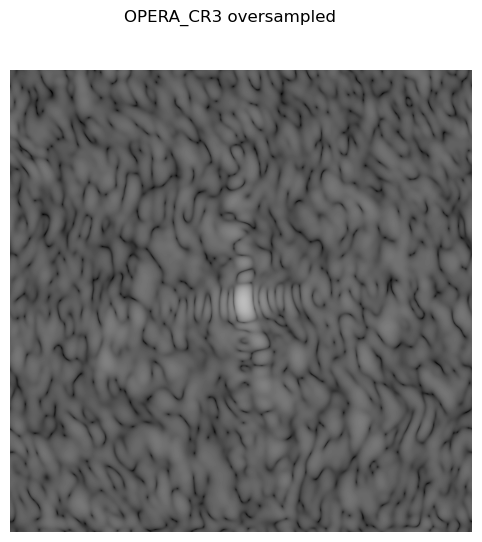

In [18]:
xpeak = []
ypeak = []
snr = []

for ID, xoff, yoff in zip(df_filter['ID'],df_filter['xloc'],df_filter['yloc']):
    # crop a patch of 10*10 with center at the calculated CR position
    pxbuff = 5
    pybuff = 5
    cropcslc = cslc[(yoff-pybuff):(yoff+pybuff),(xoff-pxbuff):(xoff+pxbuff)]
    _snr = get_snr_peak(cropcslc)

    # fig, ax = plt.subplots(figsize=(9, 6))
    # cax=ax.imshow(20*np.log10(np.abs(cropcslc)), cmap='gray',interpolation=None,
    #               extent=(xoff-pxbuff,xoff+pxbuff+1,yoff+pybuff+1,yoff-pybuff),origin='upper')
    # ax.set_aspect(1)
    # ax.axis('off')
    # fig.colorbar(cax)

    # find the peak amplitude in the 10*10 patch
    yind,xind = np.unravel_index(np.argmax(np.abs(cropcslc), axis=None), cropcslc.shape)
    
    # give a warning if the peak and the calculated postion are too far
    dyind = yind-pybuff; dxind = xind-pxbuff
    dist = math.sqrt(dyind**2+dxind**2)
    if dist > 5.0:
        warnings.warn(f'the most bright pixel and the xloc is too far for CR {ID}')
    
    # crop a patch of 32*32 but with its center at the peak
    xbuff = 32
    ybuff = 32
    ycrop = np.arange(yoff+dyind-ybuff,yoff+dyind+ybuff)
    xcrop = np.arange(xoff+dxind-xbuff,xoff+dxind+xbuff)
    cropcslc = cslc[ycrop,:][:,xcrop]

    fig, ax = plt.subplots(figsize=(9, 6))
    cax=ax.imshow(20*np.log10(np.abs(cropcslc)), cmap='gray',interpolation=None,
                  extent=(xoff+dxind-xbuff,xoff+dxind+xbuff+1,yoff+dyind+ybuff+1,yoff+dyind-ybuff),origin='upper')
    # fig.colorbar(cax)
    fig.suptitle(f'{ID} original')
    ax.axis('off')
    ax.set_aspect(1)

    # oversample this 32*32 patch by 32
    ovsFactor = 64
    cropcslc_ovs,ycrop_ovs,xcrop_ovs = oversample_slc(cropcslc,sampling=ovsFactor,y=ycrop,x=xcrop)

    fig, ax = plt.subplots(figsize=(9, 6))
    cax=ax.imshow(20*np.log10(np.abs(cropcslc_ovs)), cmap='gray',interpolation=None,
                  extent=(xoff+dxind-xbuff,xoff+dxind+xbuff+1,yoff+dyind+ybuff+1,yoff+dyind-ybuff),origin='upper',vmin=0,vmax=100)
    # fig.colorbar(cax)
    fig.suptitle(f'{ID} oversampled')
    ax.axis('off')
    ax.set_aspect(1)

    # find the peak amplitude again in a 2 x 2 patch, it correspond to 
    # (2*ovsFactor) x (2*ovsFactor) in oversampled slc
    yoff2 = int(cropcslc_ovs.shape[0]/2)
    xoff2 = int(cropcslc_ovs.shape[1]/2)
    cropcslc2 = cropcslc_ovs[yoff2-ovsFactor:yoff2+ovsFactor+1,
                           xoff2-ovsFactor:xoff2+ovsFactor+1]
    yind2,xind2 = np.unravel_index(np.argmax(abs(cropcslc2), axis=None), cropcslc2.shape)
    dyind2 = yind2-ovsFactor; dxind2 = xind2-ovsFactor

    # crop a patch of 3x3 oversampled patch with center at the peak
    cropcslc2 = cropcslc_ovs[yoff2+dyind2-1:yoff2+dyind2+2,xoff2+dxind2-1:xoff2+dxind2+2]
    ycrop2 = ycrop_ovs[yoff2+dyind2-1:yoff2+dyind2+2]
    xcrop2 = xcrop_ovs[xoff2+dxind2-1:xoff2+dxind2+2]
    xxcrop2,yycrop2 = np.meshgrid(xcrop2,ycrop2)
    xxcrop2_f = xxcrop2.flatten()
    yycrop2_f = yycrop2.flatten()
    cropcslc2_f = cropcslc2.flatten()

    # fig, ax = plt.subplots(figsize=(9, 6))
    # cax=ax.imshow(20*np.log10(np.abs(cropcslc2)), cmap='gray',interpolation=None,
    #               extent=[xcrop2[0],xcrop2[-1],ycrop2[-1],ycrop2[0]],origin='upper')
    # ax.set_aspect(1)
    # fig.suptitle(f'{ID}')
    # fig.colorbar(cax)

    # Check if pixel values in a patch are non-NaN
    valid = ~(np.isnan(cropcslc2_f))
    count_valid = np.count_nonzero(valid)

    if count_valid == 0:
        _ypeak, _xpeak = [np.nan, np.nan]

    else:
        _ypeak,_xpeak = findCR(np.abs(cropcslc2_f[valid]),yycrop2_f[valid],xxcrop2_f[valid],
                            x_bound=[xcrop2[0],xcrop2[-1]],y_bound=[ycrop2[0],ycrop2[-1]],method="para")

    xpeak.append(_xpeak)
    ypeak.append(_ypeak)
    snr.append(_snr)
    
df_filter['xloc_CR'] = xpeak
df_filter['yloc_CR'] = ypeak
df_filter['snr'] = snr
df_filter

In [19]:
df_filter = df_filter.dropna()
df_filter = df_filter[df_filter.snr > snr_threshold]
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR,snr
0,OPERA_CR3,36.187509,-120.758987,779.603309,1,13.5,2.4,701513.627735,4.007074e+06,15148,2480,15148.225547,2480.124562,15148.343446,2480.110353,14.517959


In [20]:
# Get static layers
static_layer = f'{data_dir}/{burst_id}/20230506/static_layers_{burst_id}.h5'
s3f = fsspec.open(static_layer, mode='rb', anon=True, default_fill_cache=False)

with h5py.File(s3f.open(),'r') as h5:
    incidence_angle = h5[f'{grid_path}/incidence_angle'][:]
    azimuth_angle = h5[f'{grid_path}/heading_angle'][:]

In [21]:
# Absloute geolocation error in Easting and Northing directions 
ALE_EW = (df_filter['xloc_CR'] -  df_filter['xloc_float'])*dx
ALE_NS = (df_filter['yloc_CR'] - df_filter['yloc_float'])*np.abs(dy)

# Convert to ground range and azimuth offsets
ALE_Rg, ALE_Az = en2rdr(ALE_EW, ALE_NS, azimuth_angle[df_filter['yloc'], df_filter['xloc']], incidence_angle[df_filter['yloc'], df_filter['xloc']])

# Add to the dataframe
df_filter.loc[:,"azi_angle"] = azimuth_angle[df_filter['yloc'], df_filter['xloc']]
df_filter.loc[:,"inc_angle"] = incidence_angle[df_filter['yloc'], df_filter['xloc']]
df_filter.loc[:,"ALE_EW"] = ALE_EW
df_filter.loc[:,"ALE_NS"] = ALE_NS
df_filter.loc[:,"ALE_Rg"] = ALE_Rg
df_filter.loc[:,"ALE_Az"] = ALE_Az
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,...,yloc_float,xloc_CR,yloc_CR,snr,azi_angle,inc_angle,ALE_EW,ALE_NS,ALE_Rg,ALE_Az
0,OPERA_CR3,36.187509,-120.758987,779.603309,1,13.5,2.4,701513.627735,4.007074e+06,15148,...,2480.124562,15148.343446,2480.110353,14.517959,99.388252,45.361023,0.589494,-0.1421,-0.604778,-0.236357


Text(0.5, 0.98, 'Absolute location error for 20230506 (Eastings vs Northings direction)')

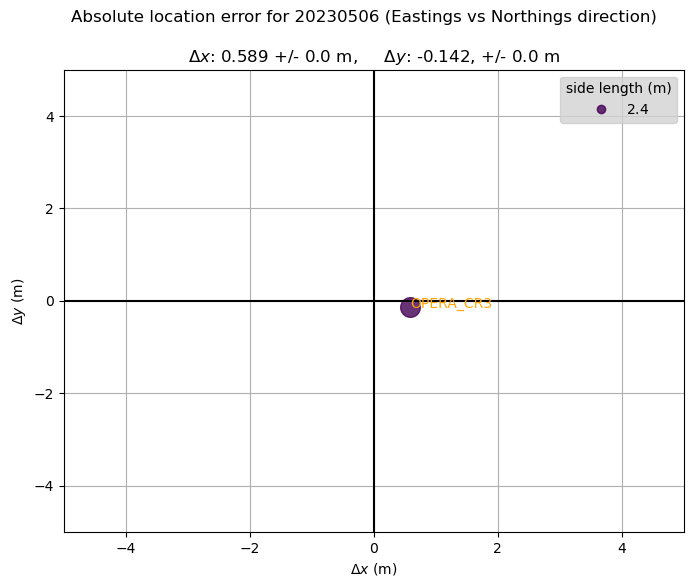

In [22]:
#plotting ALE
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(df_filter.ALE_EW, df_filter.ALE_NS, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.ID):
    ax.annotate(txt, (df_filter[df_filter['ID']==txt].ALE_EW, df_filter[df_filter['ID']==txt].ALE_NS), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'$\Delta x$: {np.round(np.nanmean(ALE_EW), 3)} +/- {np.round(np.nanstd(ALE_EW),3)} m, \
    $\Delta y$: {np.round(np.nanmean(ALE_NS),3)}, +/- {np.round(np.nanstd(ALE_NS),3)} m')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('$\Delta y$ (m)')
fig.suptitle(f'Absolute location error for {date} (Eastings vs Northings direction)')

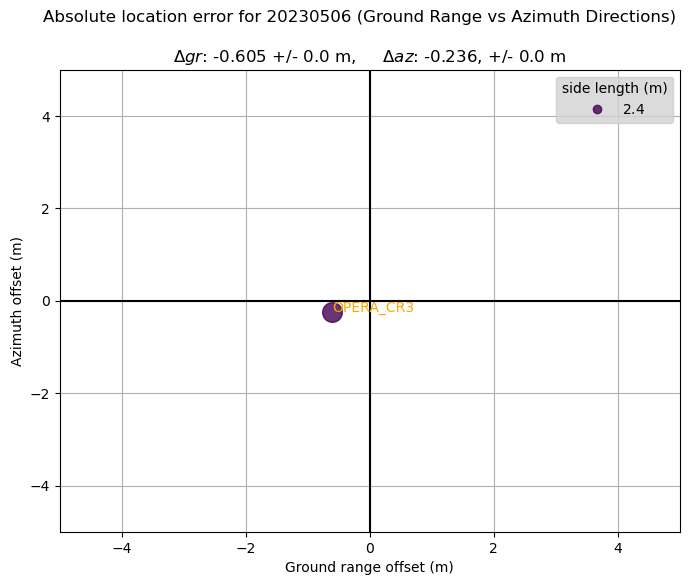

In [23]:
#plotting ALE
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(df_filter.ALE_Rg, df_filter.ALE_Az, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.ID):
    ax.annotate(txt, (df_filter[df_filter['ID']==txt].ALE_Rg, df_filter[df_filter['ID']==txt].ALE_Az), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'$\Delta gr$: {np.round(np.nanmean(ALE_Rg), 3)} +/- {np.round(np.nanstd(ALE_Rg),3)} m, \
    $\Delta az$: {np.round(np.nanmean(ALE_Az),3)}, +/- {np.round(np.nanstd(ALE_Az),3)} m')
ax.set_xlabel('Ground range offset (m)')
ax.set_ylabel('Azimuth offset (m)')
fig.suptitle(f'Absolute location error for {date} (Ground Range vs Azimuth Directions)')
fig.savefig(f'{save_dir}/pngs/ALE_CR_{burst_id}_{date}.png',dpi=300,bbox_inches='tight')


In [24]:
# Save the summary
ALE_EW_Mean = np.round(np.nanmean(ALE_EW),3)
ALE_NS_Mean = np.round(np.nanmean(ALE_NS),3)
ALE_EW_Stdev = np.round(np.nanstd(ALE_EW),3)
ALE_NS_Stdev = np.round(np.nanstd(ALE_NS),3)
ALE_Rg_Mean = np.round(np.nanmean(ALE_Rg),3)
ALE_Az_Mean = np.round(np.nanmean(ALE_Az),3)
ALE_Rg_Stdev = np.round(np.nanstd(ALE_Rg),3)
ALE_Az_Stdev = np.round(np.nanstd(ALE_Az),3)

summary = []
summary.append([date, ALE_EW_Mean, ALE_EW_Stdev, ALE_NS_Mean, ALE_NS_Stdev, ALE_Rg_Mean, ALE_Rg_Stdev, ALE_Az_Mean, ALE_Az_Stdev])
summary_df = pd.DataFrame(summary)
summary_df.to_csv(f'{save_dir}/summary/ALE.csv', mode='a', header=False)

# Save the entire dataframe to csv
df_filter.loc[:,"Date"] = [date]* len(df_filter)
df_filter.to_csv(f'{save_dir}/summary/ALE_ID.csv', mode='a')


In [25]:
# End runtime evaluation
stop = timeit.default_timer()
print(f'Time: ', (stop - start)/60, 'min.')

Time:  0.4823509402165655 min.
